**<h5></h5>**
**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Fall 2023</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: December 29, 2023 23:59 (GMT+3)</center></h4>

## **CIFAR-100 Inpainting**

### **Homework Description**

In this assignment, you are asked to design and train a convolutional neural network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the preprocessed CIFAR-100 dataset, which is created for this homework by processing the original [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 28x28 pixel resolution. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

**DO NOT CHANGE**<br>
To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. Please do not change these values.

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-100 dataset is downloadable from [this link](https://drive.google.com/file/d/1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [5]:
import gdown # Library to download files from Google Drive
!gdown 1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL # Google Drive ID of the zip file to be downloaded
!unzip -oq cifar100.zip # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL
To: /content/cifar100.zip
100% 64.1M/64.1M [00:00<00:00, 273MB/s]


### **Implementing a Custom Dataset [25 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads CIFAR-100 images from a dataset split folder. There are two split folders called train and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [6]:
class CifarDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []

        # the transformation sequence
        transform = transforms.Compose([
            transforms.Resize((32, 32), interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        # Iterating over all subdirectories (each representing a class)
        for subdir in os.listdir(root_dir):
            subdir_path = os.path.join(root_dir, subdir)

            # Making sure it's a directory
            if os.path.isdir(subdir_path):
                for img_filename in os.listdir(subdir_path):
                    img_path = os.path.join(subdir_path, img_filename)

                    # Opening the image only if it's a file
                    if os.path.isfile(img_path):
                        img = Image.open(img_path)
                        self.images.append(transform(img))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [7]:
train_dataset = CifarDataset('/content/cifar100/train')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CifarDataset('/content/cifar100/test')
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

**Do not change** the below code. If your implementation is correct, you should be seeing a grid of CIFAR-100 images properly.

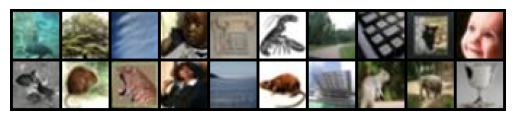

In [8]:
images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.

In [9]:
class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2), # Halving the resolution
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()  # Ensuring output is in the range [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [10]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    model.to(device)
    model.train()  # Set the model to training mode
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs = data.to(device)  # Move the input data to the correct device

            # Mask the input images by setting the pixel values from column 16 to 32 to -1
            masked_inputs = inputs.clone()
            masked_inputs[:, :, :, 16:32] = -1

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass: compute the predicted outputs by passing masked inputs to the model
            outputs = model(masked_inputs)

            # Compute the loss using the original images as the ground truth
            loss = loss_func(outputs, inputs)

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Compute the average loss for this epoch
        epoch_loss = running_loss / len(train_dataloader)
        loss_history.append(epoch_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return loss_history

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [11]:
def evaluate_model(model, test_dataloader):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    total_mse = 0.0
    total_count = 0

    with torch.no_grad():  # No gradients needed for evaluation, which saves memory and computations
        for data in test_dataloader:
            inputs = data.to(device)  # Move the input data to the correct device
            masked_inputs = inputs.clone()
            masked_inputs[:, :, :, 16:32] = -1  # Applying the same masking as during training

            outputs = model(masked_inputs)
            mse_loss = nn.functional.mse_loss(outputs, inputs, reduction='sum')
            total_mse += mse_loss.item()
            total_count += inputs.numel()

    mean_mse = total_mse / total_count  # Calculate the mean MSE over all test samples
    return mean_mse

### **Inpainting Visualization Function**


The below code will be used to visualize the outputs of the trained models later. **Do not change the codes in the cell**.

In [12]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the mean square error that your model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



Epoch 1/50, Loss: 0.1110
Epoch 2/50, Loss: 0.0803
Epoch 3/50, Loss: 0.0756
Epoch 4/50, Loss: 0.0734
Epoch 5/50, Loss: 0.0717
Epoch 6/50, Loss: 0.0707
Epoch 7/50, Loss: 0.0698
Epoch 8/50, Loss: 0.0692
Epoch 9/50, Loss: 0.0685
Epoch 10/50, Loss: 0.0680
Epoch 11/50, Loss: 0.0676
Epoch 12/50, Loss: 0.0673
Epoch 13/50, Loss: 0.0669
Epoch 14/50, Loss: 0.0666
Epoch 15/50, Loss: 0.0663
Epoch 16/50, Loss: 0.0660
Epoch 17/50, Loss: 0.0656
Epoch 18/50, Loss: 0.0654
Epoch 19/50, Loss: 0.0651
Epoch 20/50, Loss: 0.0649
Epoch 21/50, Loss: 0.0647
Epoch 22/50, Loss: 0.0644
Epoch 23/50, Loss: 0.0643
Epoch 24/50, Loss: 0.0641
Epoch 25/50, Loss: 0.0638
Epoch 26/50, Loss: 0.0636
Epoch 27/50, Loss: 0.0635
Epoch 28/50, Loss: 0.0633
Epoch 29/50, Loss: 0.0629
Epoch 30/50, Loss: 0.0629
Epoch 31/50, Loss: 0.0627
Epoch 32/50, Loss: 0.0625
Epoch 33/50, Loss: 0.0624
Epoch 34/50, Loss: 0.0624
Epoch 35/50, Loss: 0.0622
Epoch 36/50, Loss: 0.0621
Epoch 37/50, Loss: 0.0620
Epoch 38/50, Loss: 0.0618
Epoch 39/50, Loss: 0.

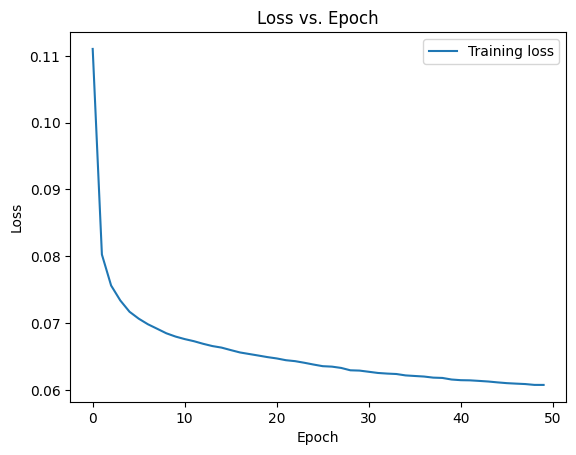

Mean Squared Error on the Test Dataset: 0.06483142979939778


In [13]:
seed_everything(464)

# Initialize the model
model = CifarAutoencoder()

model.to(device)

# Define the loss function
loss_func = nn.MSELoss()

# Set the learning rate
learning_rate = 2e-4

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set the number of epochs
num_epochs = 50

# Train the model and visualize the losses
train_loss_history = train_model(model, train_dataloader, optimizer, loss_func, num_epochs)

# Plot the training losses
plt.plot(train_loss_history, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()

# Evaluate the model
mean_square_error = evaluate_model(model, test_dataloader)
print(f'Mean Squared Error on the Test Dataset: {mean_square_error}')

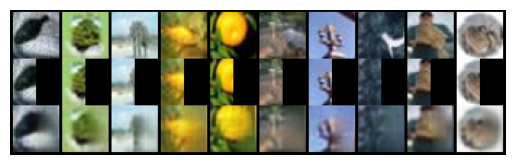

In [14]:
visualize_inpainting(model, test_dataset)